In [1]:
!pip uninstall -y mediapipe
!pip install mediapipe==0.10.14


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 18.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 4.25.8 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is incompatible.


In [2]:
!pip install torch torchvision torchaudio
!pip install torch-geometric
!pip install opencv-python mediapipe einops tqdm scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.0 MB/s eta 0:00:00


🔄 Processing videos...


Real:   0%|          | 0/635 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
Fake: 100%|██████████| 795/795 [17:02<00:00,  1.29s/it]


Epoch 1/10 | Train Loss 0.5536 Acc 0.732 | Val Loss 0.4549 Acc 0.809
Epoch 2/10 | Train Loss 0.3947 Acc 0.823 | Val Loss 0.3763 Acc 0.830
Epoch 3/10 | Train Loss 0.2899 Acc 0.888 | Val Loss 0.3743 Acc 0.876
Epoch 4/10 | Train Loss 0.2579 Acc 0.902 | Val Loss 0.2167 Acc 0.908
Epoch 5/10 | Train Loss 0.2160 Acc 0.919 | Val Loss 0.2176 Acc 0.912
Epoch 6/10 | Train Loss 0.1620 Acc 0.941 | Val Loss 0.2159 Acc 0.922
Epoch 7/10 | Train Loss 0.1520 Acc 0.948 | Val Loss 0.4531 Acc 0.887
Epoch 8/10 | Train Loss 0.1152 Acc 0.957 | Val Loss 0.2162 Acc 0.926
Epoch 9/10 | Train Loss 0.1047 Acc 0.958 | Val Loss 0.1943 Acc 0.929
Epoch 10/10 | Train Loss 0.0775 Acc 0.972 | Val Loss 0.2760 Acc 0.919


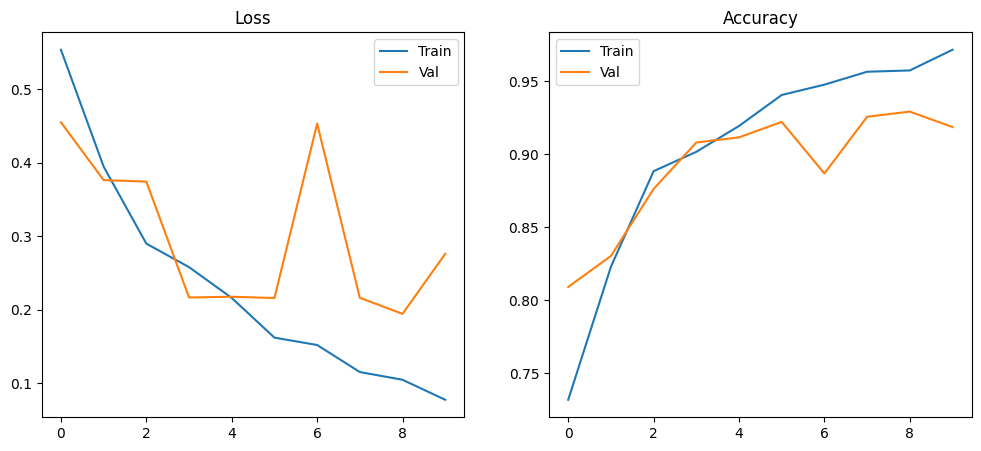

In [3]:
# ==============================================================
# Temporal-Spectral GNN + Hierarchical Attention
# DeepFake Detection (Binary: Real vs Fake)
# ==============================================================

# ======================
# 1. Imports
# ======================
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.nn import GATConv

import mediapipe as mp
from sklearn.model_selection import train_test_split

# ======================
# 2. Dataset Paths
# ======================
BASE_PATH = "/content/sample_data/dataset"

DATASET = {
    "Real": os.path.join(BASE_PATH, "real"),
    "Fake": os.path.join(BASE_PATH, "fake")
}

LABELS = {"Real": 0, "Fake": 1}

# ======================
# 3. Face Extraction
# ======================
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=False,
    max_num_faces=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

def extract_faces(video_path, max_frames=100):
    cap = cv2.VideoCapture(video_path)
    faces = []

    while cap.isOpened() and len(faces) < max_frames:
        ret, frame = cap.read()
        if not ret:
            break

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(rgb)

        if results.multi_face_landmarks:
            h, w, _ = frame.shape
            xs, ys = [], []

            for lm in results.multi_face_landmarks[0].landmark:
                xs.append(int(lm.x * w))
                ys.append(int(lm.y * h))

            x1, x2 = max(min(xs), 0), min(max(xs), w)
            y1, y2 = max(min(ys), 0), min(max(ys), h)

            face = frame[y1:y2, x1:x2]
            if face.size > 0:
                faces.append(cv2.resize(face, (224, 224)))

    cap.release()
    return faces

# ======================
# 4. Face Regions
# ======================
def split_regions(face, grid=3):
    h, w, _ = face.shape
    regions = []
    dh, dw = h // grid, w // grid

    for i in range(grid):
        for j in range(grid):
            regions.append(face[i*dh:(i+1)*dh, j*dw:(j+1)*dw])
    return regions

# ======================
# 5. Features
# ======================
def spatial_features(region):
    gray = cv2.cvtColor(region, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (32, 32))
    return gray.flatten() / 255.0

def spectral_features(region):
    gray = cv2.cvtColor(region, cv2.COLOR_BGR2GRAY)
    f = np.fft.fft2(gray)
    fshift = np.fft.fftshift(f)
    mag = np.log1p(np.abs(fshift))
    mag = cv2.resize(mag, (16, 16))

    max_val = np.max(mag)
    if max_val == 0:
        return np.zeros(16 * 16)

    return mag.flatten() / max_val

# ======================
# 6. Graph Construction
# ======================
def build_graph(faces):
    node_features = []
    edge_index = []
    node_id = 0
    frame_nodes = []

    for face in faces:
        regions = split_regions(face)
        current_nodes = []

        for r in regions:
            sp = spatial_features(r)
            spec = spectral_features(r)
            feat = np.concatenate([sp, spec])
            feat = (feat - feat.mean()) / (feat.std() + 1e-6)

            node_features.append(feat)
            current_nodes.append(node_id)
            node_id += 1

        frame_nodes.append(current_nodes)

    # Temporal edges
    for t in range(len(frame_nodes) - 1):
        for n1, n2 in zip(frame_nodes[t], frame_nodes[t + 1]):
            edge_index.append([n1, n2])
            edge_index.append([n2, n1])

    x = torch.tensor(np.array(node_features), dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    return Data(x=x, edge_index=edge_index)

# ======================
# 7. TS-GNN Model
# ======================
class TS_GNN(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.gnn1 = GATConv(in_dim, 128, heads=4)
        self.gnn2 = GATConv(512, 128)
        self.dropout = nn.Dropout(0.3)

        self.att_region = nn.Linear(128, 1)
        self.fc = nn.Linear(128, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = F.elu(self.gnn1(x, edge_index))
        x = self.dropout(x)
        x = F.elu(self.gnn2(x, edge_index))
        x = self.dropout(x)

        num_regions = 9
        num_frames = x.size(0) // num_regions
        x = x.view(num_frames, num_regions, 128)

        alpha = torch.softmax(self.att_region(x), dim=1)
        x = (x * alpha).sum(dim=1)

        x = x.mean(dim=0, keepdim=True)
        return self.fc(x)   # LOGITS (NO SIGMOID)

# ======================
# 8. Load Dataset
# ======================
def load_dataset(val_split=0.2):
    graphs, labels = [], []

    print("🔄 Processing videos...")
    for cls, path in DATASET.items():
        for vid in tqdm(os.listdir(path), desc=cls):
            faces = extract_faces(os.path.join(path, vid))
            if len(faces) < 2:
                continue
            graphs.append(build_graph(faces))
            labels.append(LABELS[cls])

    labels = torch.tensor(labels, dtype=torch.float)

    idx = np.arange(len(graphs))
    train_idx, val_idx = train_test_split(idx, test_size=val_split, random_state=42)

    return (
        [graphs[i] for i in train_idx],
        labels[train_idx],
        [graphs[i] for i in val_idx],
        labels[val_idx]
    )

# ======================
# 9. Training
# ======================
def train(model, train_graphs, train_labels, val_graphs, val_labels, epochs=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
    criterion = nn.BCEWithLogitsLoss()

    train_loss_list, val_loss_list = [], []
    train_acc_list, val_acc_list = [], []

    for epoch in range(epochs):
        model.train()
        total_loss, correct = 0, 0

        for i, g in enumerate(train_graphs):
            y = train_labels[i].view(1, 1)

            optimizer.zero_grad()
            logits = model(g)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            prob = torch.sigmoid(logits)
            correct += ((prob > 0.5).float() == y).sum().item()
            total_loss += loss.item()

        train_loss = total_loss / len(train_graphs)
        train_acc = correct / len(train_graphs)

        model.eval()
        val_loss, correct = 0, 0

        with torch.no_grad():
            for i, g in enumerate(val_graphs):
                y = val_labels[i].view(1, 1)
                logits = model(g)
                loss = criterion(logits, y)

                prob = torch.sigmoid(logits)
                correct += ((prob > 0.5).float() == y).sum().item()
                val_loss += loss.item()

        val_loss /= len(val_graphs)
        val_acc = correct / len(val_graphs)

        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss {train_loss:.4f} Acc {train_acc:.3f} | "
              f"Val Loss {val_loss:.4f} Acc {val_acc:.3f}")

    # Plot
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(train_loss_list, label="Train")
    plt.plot(val_loss_list, label="Val")
    plt.title("Loss"); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_acc_list, label="Train")
    plt.plot(val_acc_list, label="Val")
    plt.title("Accuracy"); plt.legend()
    plt.show()

# ======================
# 10. Run
# ======================
train_graphs, train_labels, val_graphs, val_labels = load_dataset()
model = TS_GNN(train_graphs[0].x.shape[1])
train(model, train_graphs, train_labels, val_graphs, val_labels, epochs=10)
